In [1]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy


IBMQ.load_account()
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

provider = IBMQ.get_provider(hub='ibm-q')


# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

/tmp/ipykernel_80/2004354736.py:5: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In this Jupyter Notebook, we will focus on determining the time required for each gate to execute its operation. Additionally, we will measure the readout error. To extract these informations, we will use the class BackendProperties (https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendProperties.html).

Let's begin with timing. It's crucial to distinguish between two types of gates: one-qubit gates and two-qubit gates. Specifically, according to the Solovay-Kitaev theorem, we understand that using a specific set of one-qubit gates along with the CNOT gate, it is feasible to execute all potential operations within a certain margin of error. Due to this reason, IBM quantum computers have a designated set of basis gates. We will calculate the timing solely for this specific basis set. Concerning the CNOT operation, timing is computed only for qubits capable of communicating with each other. As we are examining a computer with 7 qubits, the qubit pairs under examination are (0, 1), (1, 2), (1, 3), (3, 5), (4, 5), and (5, 6). We will calculate the average timing for these pairs. For single-qubit gates, we will apply them to each qubit individually and determine the average timing across all qubits.

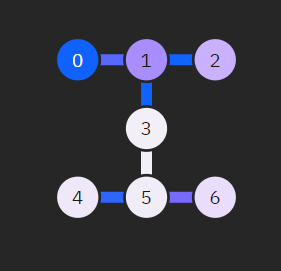

In [35]:
#return timing of CNOT gate
def time_cx(backend_properties, gate):
    gate_time=[]
    for i in range(6):
        if i==2:
            time=backend_properties.gate_length(gate,[1,3])
            gate_time.append(time)
            #print(time)
        elif i==3:
            time=backend_properties.gate_length(gate,[3,5])
            gate_time.append(time)
            #print(time)
        else:
            time=backend_properties.gate_length(gate,[i,i+1])
            gate_time.append(time)
            #print(time)
       
    return gate_time

#return timing of single qubit gate    
def time_single(backend_properties, gate):
    gate_time=[]
    for i in range(7):
        time=backend_properties.gate_length(gate,i)
        gate_time.append(time)
    return gate_time

#calculate the average
def average(values):
    somma=0
    for val in values:
        somma=somma+val
    mean_value=somma/len(values)
    return mean_value

In [7]:
backend = least_busy(provider.backends(simulator=False, n_qubits=7))  # select the least busy backend

# backend's name
backend_name = backend.name()

# backend's properties
backend_properties = backend.properties()
gate=backend.configuration().basis_gates # to know what are the basis gates of the backend

print("The backend we are using is", backend_name)
print("The basis gates are", gate)



The backend we are using is ibm_nairobi
The basis gates are ['id', 'rz', 'sx', 'x', 'cx', 'reset']


In [36]:
gates_time=[]
for i in gate:
    if i!= 'cx':
        gate_time=time_single(backend_properties, i)
        average_gate=average(gate_time)
        gates_time.append(average_gate)
        print("The average time for the gate",i, "is", average_gate)
    else:
        gate_time=time_cx(backend_properties, 'cx')
        average_gate=average(gate_time)
        gates_time.append(average_gate)
        print("The average time for the gate",i, "is", average_gate)
        

The average time for the gate id is 3.5555555555555554e-08
The average time for the gate rz is 0.0
The average time for the gate sx is 3.5555555555555554e-08
The average time for the gate x is 3.5555555555555554e-08
The average time for the gate cx is 3.1288888888888885e-07
The average time for the gate reset is 5.5964444444444435e-06


Notice we are using the least busy quantum computer but we don't lose generality, because all the 7 qubits computers have the same topological scheme and the same basis gate.

Now we can move on to analyze the readout error, which is crucial if we aim to construct a realistic simulator. Without knowledge of this value, we cannot implement complete error correction. 

The readout error is the mistake that occurs when we measure a qubit. Simply put, it can happen that our qubit's state is 0 (1), so upon measurement, we expect to find 0 (1), but due to measurement-induced errors, we find 1 (0) instead. This implies that there are two probabilities of readout error: 1) the probability of measuring 1 when the actual value is 0, and 2) the probability of measuring 0 when the value is 1. Typically, in real quantum computers, there is an effort to balance these two probability values.

At each qubit, one or two error probabilities will be associated. It's possible to obtain these values graphically by visiting the IBM page displaying various quantum computers, clicking on the relevant resource, and hovering the mouse over the various qubits. In this notebook, the choice was made to obtain these values using code, ensuring no loss of generality in utilizing the least busy quantum computer.

In [37]:
qubit_error=[]
for i in range (7):
    read_out_error=backend_properties.readout_error(i)
    qubit_error.append(read_out_error)
    print("The read out error for the qubit", i, "is", read_out_error)

The read out error for the qubit 0 is 0.030100000000000016
The read out error for the qubit 1 is 0.02410000000000001
The read out error for the qubit 2 is 0.029299999999999993
The read out error for the qubit 3 is 0.05230000000000001
The read out error for the qubit 4 is 0.0232
The read out error for the qubit 5 is 0.05230000000000001
The read out error for the qubit 6 is 0.017100000000000004
